In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive')

In [3]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sat Jun 24 09:45:01 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   51C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

最开始，我们固定经纬度，选择了经度为88.542，纬度为0的从1949年一月到2023年五月包括11个不同属性的数据的一级的降水量数据

- 完整性检查：你需要确保你的时间序列数据是完整的，没有缺失值。如果存在缺失值，你可能需要对它们进行插值或其他形式的处理。

- 数据规范化或标准化：LSTM模型通常在规范化或标准化的数据上工作得更好。你可以使用如 MinMaxScaler 或 StandardScaler 等方法将你的数据转换到一个特定的范围或分布。

- 序列长度的设定：在训练LSTM模型时，你需要设定一个时间窗口来作为模型的输入。这通常涉及到把你的时间序列数据转换成一系列的滑动窗口序列。

- 训练集和测试集的划分：你需要将你的时间序列数据划分为训练集和测试集。由于时间序列数据的序列性质，你通常需要按照时间顺序进行划分，而不是随机划分。

- 异常值处理：时间序列数据中可能存在的异常值可能会影响模型的性能。你可能需要检测并处理这些异常值。

- 特征选择：如果你的数据中包含多个特征，你可能需要进行特征选择来确定哪些特征对预测最有用。

注意，LSTM模型并不要求时间序列数据是平稳的，这是它与一些传统的时间序列模型（如ARIMA）的一个主要区别。然而，如果你的数据存在明显的趋势或季节性，移除这些成分可能会帮助模型更好地捕获其他的模式。

In [4]:
import pandas as pd
df = pd.read_csv('output_1145_1.csv')
df.head()

,time,prate,pr_wtr,pres,air,tmp
0,1948/1/1,1.910000e-06,1.418707,101080.0,234.98190,252.09000
1,1948/2/1,2.180000e-06,2.181035,100300.0,237.22414,253.86000
2,1948/3/1,3.610000e-06,2.823545,100390.0,242.24744,253.00000
3,1948/4/1,9.530000e-07,2.155997,101290.0,246.99667,257.83002
4,1948/5/1,1.400000e-05,7.325806,101190.0,267.25230,266.32000


In [5]:
from statsmodels.tsa.stattools import adfuller

df['time'] = pd.to_datetime(df['time'])
df.set_index('time', inplace=True)

def adf_test(timeseries):
    # Perform Dickey-Fuller test
    dftest = adfuller(timeseries, autolag='AIC')
    return dftest[1]  # Return p-value

# Assume df is a pandas DataFrame where each column is a time series
p_values = df.apply(adf_test)

print(p_values)

prate     8.000102e-12
pr_wtr    3.948611e-07
pres      9.062099e-10
air       2.700682e-02
tmp       1.556175e-02
dtype: float64


以下是使用LSTM预测时间序列数据的基本步骤：

数据预处理。在使用LSTM之前，你需要将你的数据转换为合适的形状。LSTM要求输入的形状为[samples, time steps, features]。

创建模型。使用Keras创建一个LSTM模型。

训练模型。用你的训练数据训练模型。

预测。用你的模型进行预测。

In [15]:
import numpy as np
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

# 假设你有一个名为df的Pandas DataFrame，其中包含time, prate, pr_wtr和pres列
# 首先，我们将数据集划分为训练集和测试集
#train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, shuffle=False)

# 从训练集中提取特征和目标
#train_X = train_df[['pr_wtr', 'pres']].values
#train_y = train_df['prate'].values

# 同样，从测试集中提取特征和目标
#test_X = test_df[['pr_wtr', 'pres']].values
#test_y = test_df['prate'].values

# 总的数据量
n_total = len(df)

# 训练数据的数量，例如，前80%的数据
n_train = int(n_total * 0.8)

# 划分训练集和测试集
train_df = df[:n_train]
test_df = df[n_train:]

# 对于特征和目标变量进行划分
train_X = train_df[['pr_wtr', 'pres', 'air', 'tmp']].values
train_y = train_df['prate'].values
test_X = test_df[['pr_wtr', 'pres', 'air', 'tmp']].values
test_y = test_df['prate'].values

#train_df['time'] = pd.to_datetime(train_df['time'])
#train_df.set_index('time', inplace=True)

#test_df['time'] = pd.to_datetime(test_df['time'])
#test_df.set_index('time', inplace=True)

# 数据归一化
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

train_X = scaler_X.fit_transform(train_X)
train_y = scaler_y.fit_transform(train_y.reshape(-1, 1))

test_X = scaler_X.transform(test_X)
test_y = scaler_y.transform(test_y.reshape(-1, 1))

# reshape input to be [samples, time steps, features]
train_X = np.reshape(train_X, (train_X.shape[0], 1, train_X.shape[1]))
test_X = np.reshape(test_X, (test_X.shape[0], 1, test_X.shape[1]))

# 创建LSTM模型
# model = Sequential()
# model.add(LSTM(50, input_shape=(train_X.shape[1], train_X.shape[2])))
# model.add(Dense(1))
# model.compile(loss='mean_squared_error', optimizer='adam')


# 创建 LSTM 模型
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(Dropout(0.2))  # dropout layer
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))  # dropout layer
model.add(LSTM(units=50))
model.add(Dropout(0.2))  # dropout layer
model.add(Dense(1))



# 编译模型
model.compile(optimizer='adam', loss='mean_squared_error')

# 训练模型
history = model.fit(train_X, train_y, epochs=150, batch_size=576, verbose=2, validation_data=(test_X, test_y))

# 使用训练的模型进行预测
train_predict = model.predict(train_X)
test_predict = model.predict(test_X)

# 将预测结果反归一化，以便我们可以在原始尺度上解释它们
train_predict = scaler_y.inverse_transform(train_predict)
train_y = scaler_y.inverse_transform(train_y)
test_predict = scaler_y.inverse_transform(test_predict)
test_y = scaler_y.inverse_transform(test_y)


Epoch 1/150
2/2 - 7s - loss: 0.0667 - val_loss: 0.0641 - 7s/epoch - 4s/step
Epoch 2/150
2/2 - 0s - loss: 0.0636 - val_loss: 0.0608 - 41ms/epoch - 21ms/step
Epoch 3/150
2/2 - 0s - loss: 0.0605 - val_loss: 0.0575 - 37ms/epoch - 18ms/step
Epoch 4/150
2/2 - 0s - loss: 0.0574 - val_loss: 0.0542 - 39ms/epoch - 19ms/step
Epoch 5/150
2/2 - 0s - loss: 0.0542 - val_loss: 0.0509 - 37ms/epoch - 18ms/step
Epoch 6/150
2/2 - 0s - loss: 0.0511 - val_loss: 0.0474 - 37ms/epoch - 19ms/step
Epoch 7/150
2/2 - 0s - loss: 0.0477 - val_loss: 0.0439 - 38ms/epoch - 19ms/step
Epoch 8/150
2/2 - 0s - loss: 0.0446 - val_loss: 0.0404 - 37ms/epoch - 18ms/step
Epoch 9/150
2/2 - 0s - loss: 0.0412 - val_loss: 0.0368 - 38ms/epoch - 19ms/step
Epoch 10/150
2/2 - 0s - loss: 0.0380 - val_loss: 0.0333 - 36ms/epoch - 18ms/step
Epoch 11/150
2/2 - 0s - loss: 0.0346 - val_loss: 0.0300 - 37ms/epoch - 19ms/step
Epoch 12/150
2/2 - 0s - loss: 0.0319 - val_loss: 0.0270 - 37ms/epoch - 18ms/step
Epoch 13/150
2/2 - 0s - loss: 0.0290 - va

In [16]:
# 输出最佳模型的loss, val_loss
print('Best loss: ', min(history.history['loss']))
print('Best val_loss: ', min(history.history['val_loss']))

Best loss:  0.011671203188598156
Best val_loss:  0.01474025659263134


In [17]:
model.evaluate(test_X, test_y)

6/6 [==============================] - 0s 5ms/step - loss: 0.0516


0.051572345197200775

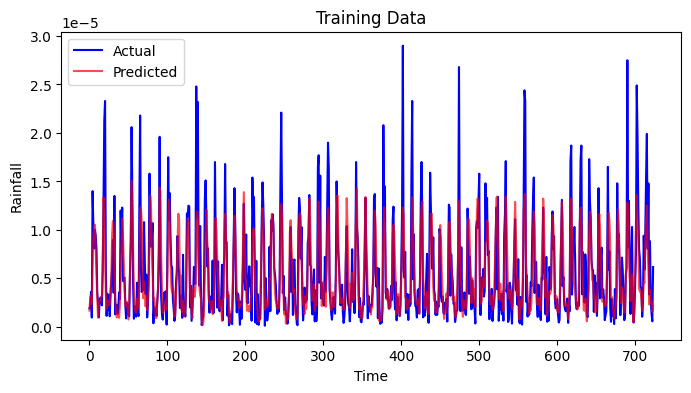

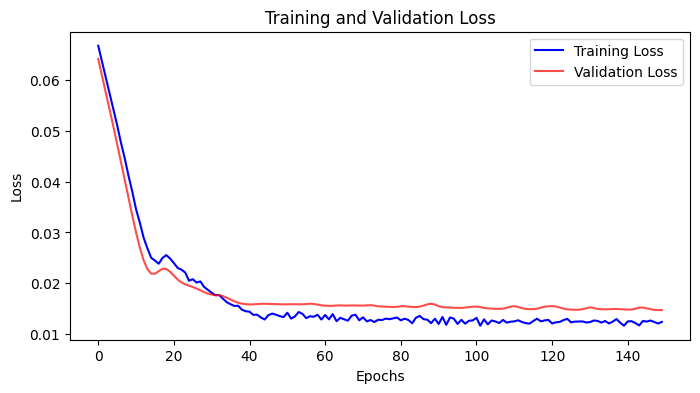

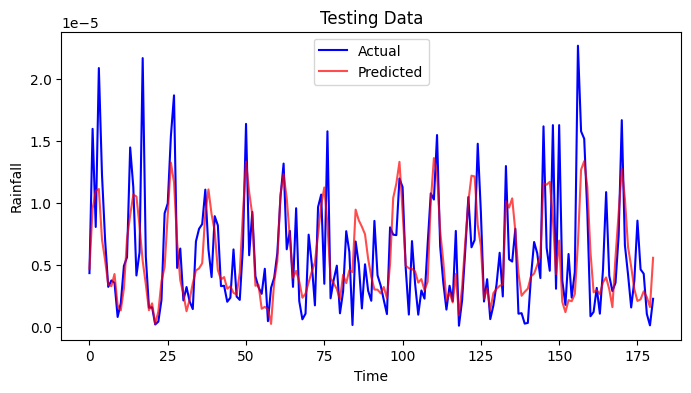

In [18]:
# 绘制训练效果图
import matplotlib.pyplot as plt
plt.figure(figsize=(8, 4))
plt.plot(train_y, color='blue', label='Actual')
plt.plot(train_predict, alpha=0.7, color='red', label='Predicted')
plt.title('Training Data')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()

# 绘制loss图
plt.figure(figsize=(8, 4))
plt.plot(history.history['loss'], color='blue', label='Training Loss')
plt.plot(history.history['val_loss'], alpha=0.7, color='red', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# 绘制测试效果图
plt.figure(figsize=(8, 4))
plt.plot(test_y, color='blue', label='Actual')
plt.plot(test_predict, alpha=0.7, color='red', label='Predicted')
plt.title('Testing Data')
plt.xlabel('Time')
plt.ylabel('Rainfall')
plt.legend()
plt.show()